# i. Perkenalan

Nama: Mujahid  
Bath: RMT-022  

**Latar Belakang Masalah**: Menurut World Health Organization (WHO), stroke merupakan penyebab kematian terbesar kedua di seluruh dunia, bertanggung jawab atas sekitar 11% dari total kematian. Stroke adalah kondisi serius yang dapat mengakibatkan dampak jangka panjang yang signifikan pada kualitas hidup individu. Oleh karena itu, penting untuk dapat memprediksi potensi risiko stroke secara dini. Prediksi risiko stroke menjadi krusial dalam upaya pencegahan dan penanganan lebih lanjut untuk mengurangi dampak buruk dari penyakit ini. Dalam konteks ini, pengembangan metode atau alat prediksi risiko stroke menjadi perhatian penting dalam dunia kesehatan global.  

**Objektif**: Membangun model klasifikasi untuk meramalkan risiko stroke berdasarkan faktor-faktor risiko serta mengintegrasikan model ini dalam pengelolaan kesehatan untuk identifikasi dini risiko stroke. 

## Conceptual Problems

1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !

Latar belakang adanya bagging adalah untuk meningkatkan akurasi prediksi model dengan menggabungkan beberapa model (misalnya, Decision Trees) yang dilatih pada dataset yang sama, tetapi dengan subset data yang berbeda, kemudian mengambil hasil rata-rata atau mayoritas dari prediksi mereka.
Cara kerja bagging adalah dengan mengumpulkan banyak "pendapat" dari model-model yang berbeda, yang secara kolektif cenderung menghasilkan hasil yang lebih akurat daripada hanya mengandalkan satu model tunggal.

2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !

Random Forest bekerja dengan menggabungkan sejumlah besar pohon keputusan independen, sementara XGBoost fokus pada pengembangan pohon keputusan secara berurutan dengan menekankan perbaikan pada prediksi yang salah sebelumnya

3. Jelaskan apa yang dimaksud dengan Cross Validation ! 

Cross Validation adalah teknik yang digunakan untuk mengukur kinerja model machine learning dengan membagi data menjadi beberapa subset, melatih model pada beberapa subset tersebut, dan menguji model pada subset yang lain untuk memastikan generalisasi yang lebih baik.

# ii. Import Libraries

In [1]:
import json
import joblib
import pandas as pd
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, f_oneway, chi2_contingency

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# iii. Data Loading

In [2]:
# baca data csv
filename = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(filename)

In [3]:
# tampilkan data 5 teratas
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# tampilkan 5 data terbawah
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [5]:
# cek ringkasan umum data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
# cek ukuran baris dan kolom data
df.shape

(5110, 12)

In [7]:
# cek nama-nama kolom
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

# iv. Exploratory Data Analysis (EDA)

In [8]:
# cek data duplikat
df.duplicated().sum()

0

In [9]:
# Menghitung persentase nilai yang hilang dalam suatu dataset.
missing_values = df.isnull().sum()
total_values = len(df)

percentage_missing = (missing_values / total_values) * 100

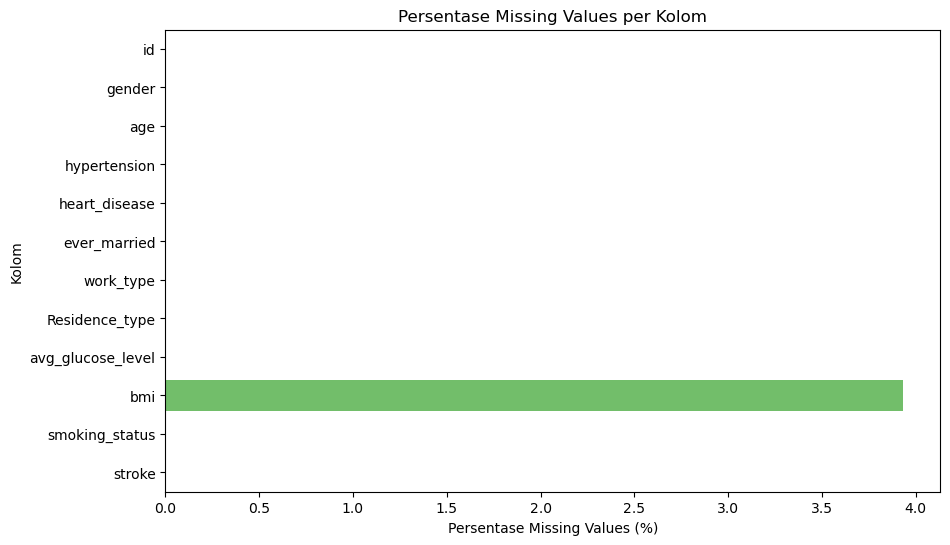

In [10]:
# Mengatur ukuran gambar plot menjadi 10x6.
plt.figure(figsize=(10, 6))

# Membuat plot bar dengan seaborn untuk menampilkan persentase nilai yang hilang per kolom.
sns.barplot(x=percentage_missing.values, y=percentage_missing.index, palette='viridis')

# Menambahkan judul plot.
plt.title('Persentase Missing Values per Kolom')
# Menambahkan label sumbu-x dan sumbu-y.
plt.xlabel('Persentase Missing Values (%)')
plt.ylabel('Kolom')

# Menampilkan plot.
plt.show()

Hasil visualisasi barplot menunjukkan bahwa sekitar 4% dari data pada kolom BMI memiliki nilai yang hilang (missing value). Hal ini menunjukkan bahwa sebagian kecil dari data BMI dalam dataset tidak memiliki nilai yang lengkap. Untuk analisis lebih lanjut, perlu dipertimbangkan apakah akan mengisi nilai yang hilang atau mengatasi masalah tersebut dengan cara lain sesuai dengan tujuan analisis yang akan dilakukan

In [11]:
numeric_features = ["age", "avg_glucose_level", "bmi"]

for feature in numeric_features:
    skewness = skew(df[feature])
    print(f"Skewness of {feature}: {skewness:.2f}")

Skewness of age: -0.14
Skewness of avg_glucose_level: 1.57
Skewness of bmi: nan


Hasil pengukuran skewness menunjukkan bahwa distribusi usia (age) memiliki sedikit skewness negatif sebesar -0.14, yang menunjukkan sedikit kemiringan ke kiri. Distribusi avg_glucose_level memiliki skewness positif sebesar 1.57, menunjukkan kemiringan yang signifikan ke kanan, yang mungkin mengindikasikan adanya ekor panjang di sebelah kanan distribusi tersebut.

Namun, perlu diperhatikan bahwa nilai skewness untuk BMI (bmi) adalah NaN (Not-a-Number), yang mengindikasikan adanya masalah atau nilai yang hilang dalam data BMI. Oleh karena itu, diperlukan pemrosesan lebih lanjut untuk menangani nilai yang hilang atau potensi masalah dalam data BMI sebelum analisis lebih lanjut.

In [12]:
for col in ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']:
    print(df[col].value_counts())
    print()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

0    4612
1     498
Name: hypertension, dtype: int64

0    4834
1     276
Name: heart_disease, dtype: int64

Yes    3353
No     1757
Name: ever_married, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

0    4861
1     249
Name: stroke, dtype: int64



In [13]:
# fungsi visualisasi boxplot untuk mengetahui outlier
def create_boxplot_with_outlier(dataframe):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=dataframe, orient='horizontal')
    plt.title('Boxplot dengan Outlier')
    
    plt.show()

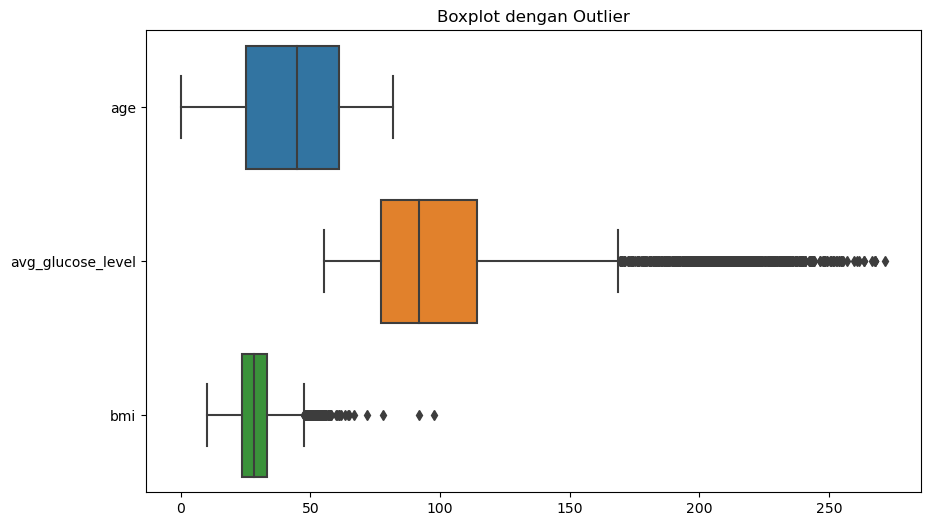

In [14]:
# menerapkan fungsi visualisasi boxplot pada dataframe
create_boxplot_with_outlier(df[['age', 'avg_glucose_level', 'bmi']])

Age: Distribusi usia (age) tidak memiliki outlier, yang menunjukkan bahwa data usia cenderung homogen tanpa nilai yang sangat ekstrim.

Avg Glucose Level: Terdapat outlier pada distribusi tingkat glukosa rata-rata (avg_glucose_level), yang menunjukkan bahwa ada sejumlah kasus dengan nilai glukosa yang sangat tinggi atau rendah dibandingkan dengan mayoritas populasi.

BMI (Body Mass Index): Distribusi indeks massa tubuh (bmi) juga memiliki outlier, yang menunjukkan bahwa ada sejumlah kasus dengan nilai BMI yang sangat tinggi atau rendah dibandingkan dengan mayoritas populas

In [15]:
# fungsi visualisasi distribusi data
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    
    fig = plt.figure(figsize=(15, 12))
    
    # Melakukan iterasi pada variabel yang akan digambar histogramnya.
    for i, var_name in enumerate(variables):
        # Menambahkan subplot dengan jumlah baris n_rows dan kolom n_cols.
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        # Menggambar histogram dari variabel dengan jumlah bins sebanyak n_bins.
        df[var_name].hist(bins=n_bins,ax=ax)
        # Menetapkan judul subplot dengan nama variabel.
        ax.set_title(var_name)
    # Mengatur tata letak subplot agar tampilan lebih baik.
    fig.tight_layout() 
    # Menampilkan gambar dengan histogram-histogram tersebut.
    plt.show()

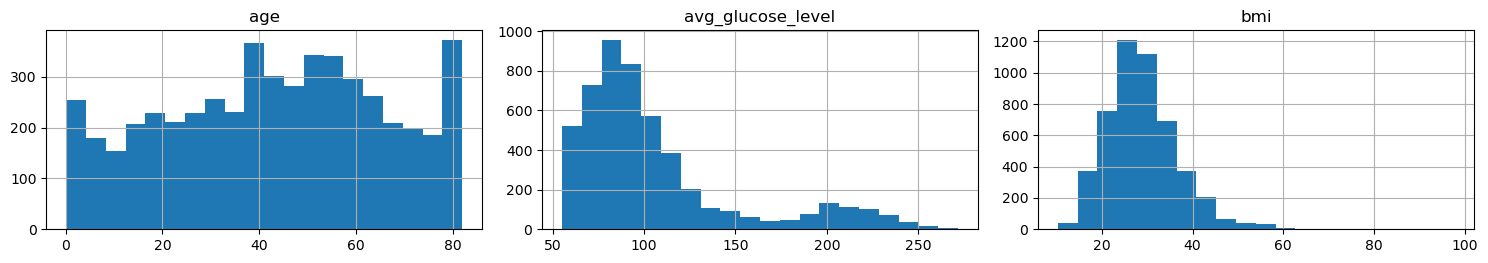

In [16]:
draw_histograms(df, ['age', 'avg_glucose_level', 'bmi'], 5, 3, 20)

Kolom `avg_glucose_level` dan `bmi` terlihat skew.

In [17]:
# Normalized value counts
df.stroke.value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

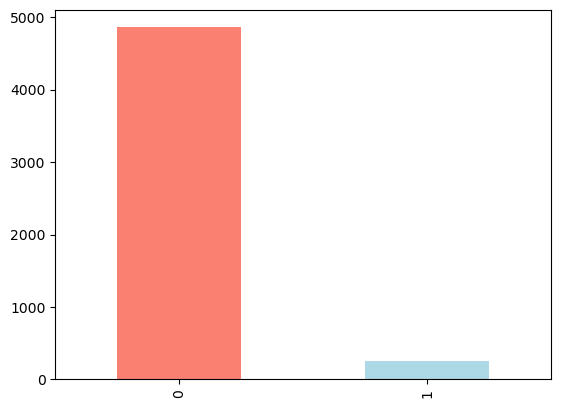

In [18]:
df.stroke.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

Insight dari distribusi nilai target (stroke) adalah bahwa mayoritas data (sekitar 95.13%) memiliki nilai 0, yang mengindikasikan bahwa mayoritas observasi dalam dataset ini adalah non-stroke. Sementara itu, hanya sekitar 4.87% observasi yang memiliki nilai 1, yang menunjukkan bahwa kasus stroke dalam dataset ini merupakan minoritas. Dengan demikian, perlu berhati-hati dalam menangani ketidakseimbangan kelas ini saat membangun model prediksi stroke.

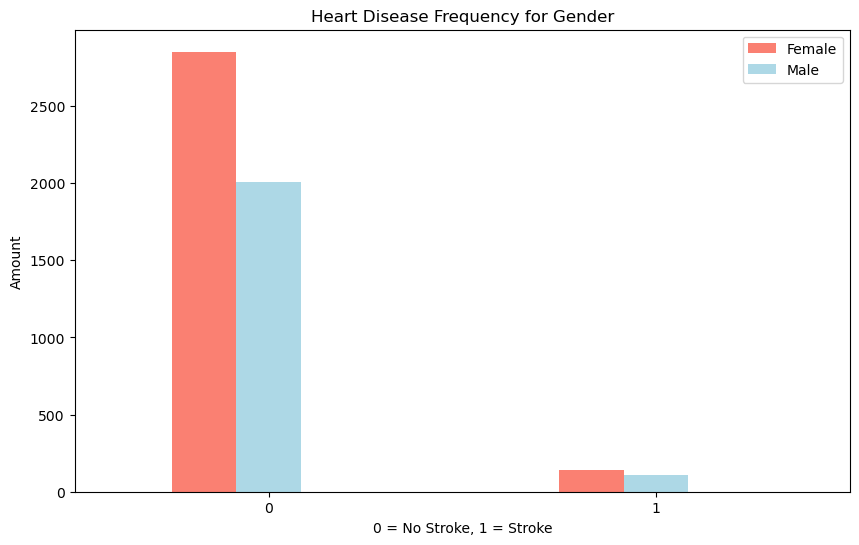

In [19]:
# Create a plot
pd.crosstab(df.stroke, df.gender).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])

# Add some attributes to it
plt.title("Heart Disease Frequency for Gender")
plt.xlabel("0 = No Stroke, 1 = Stroke")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

Dari visualisasi di atas, `Female` lebih banyak terkena stroke dibanding `Male`.

C:\Users\User\AppData\Local\Temp\ipykernel_1796\2572033417.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.iloc[:, 1:].corr()


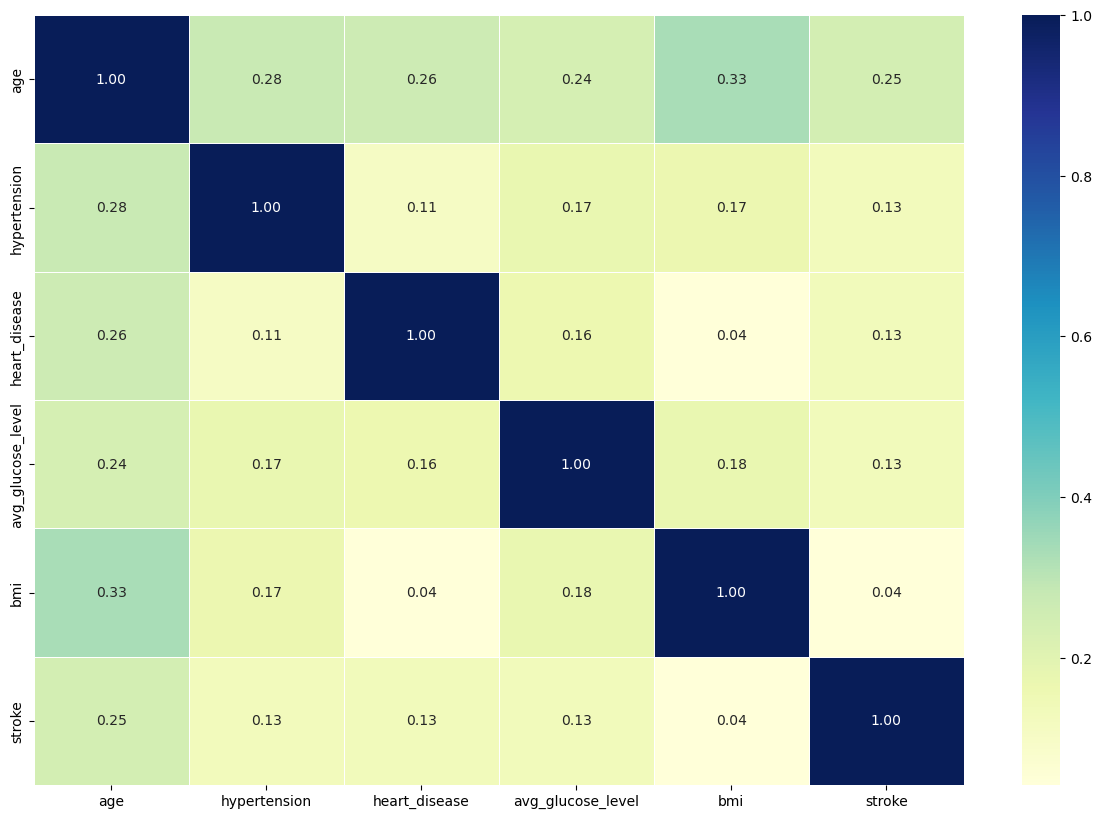

In [20]:
# Let's make it look a little prettier
corr_matrix = df.iloc[:, 1:].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu")
plt.show()

Pada visualisasi korelasi diatas, insight yang bisa diambil adalah bahwa korelasi tiap variabel tidak ada yang terlalu kuat, nilai korelasi paling tinggi adalah 0.33

# v. Feature Engineering

In [21]:
# Everything except target variable
X = df.drop("stroke", axis=1)

# Target variable
y = df.stroke

In [22]:
# drop kolom id
X.drop('id', axis=1, inplace=True)

In [23]:
# merubah nama kolom menjadi huruf kecil semua
X.columns = X.columns.str.lower()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2,
                                                    random_state = 42) 

## drop missing value pada train

In [25]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index] 

## drop missing value pada test

In [26]:
X_test.dropna(inplace=True)
y_test = y_test[X_test.index] 

In [28]:
# reset index untuk keperluan penggabungan data
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [29]:
# Tentukan kolom kategorikal dan kolom numerik
categorical_features = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "residence_type", "smoking_status"]
numeric_features = ["age", "avg_glucose_level", "bmi"]

## fungsi-fungsi

In [30]:
# fungsi chi squared
def chi_squared_feature_selection(X, y, alpha=0.05):
    """
    Memilih fitur menggunakan uji Chi-Square.

    Parameters:
    - X: DataFrame atau numpy array, berisi fitur-fitur kategorikal.
    - y: Series atau numpy array, berisi kolom target.
    - alpha: Tingkat signifikansi (default=0.05).

    Returns:
    - selected_features: List nama fitur terpilih.
    - chi2_scores: List nilai statistik Chi-Square untuk masing-masing fitur.
    - p_values: List nilai p-value untuk masing-masing fitur.
    """
    selected_features = []
    non_selected_features = []

    for feature in X.columns:
        contingency_table = pd.crosstab(X[feature], y)
        _, p, _, _ = chi2_contingency(contingency_table)
        
        if p < alpha:
            selected_features.append(feature)
        else:
            non_selected_features.append(feature)
    
    return selected_features, non_selected_features

# fungsi uji anova
def feature_selection_anova(X, y, alpha=0.05):
    """
    Melakukan feature selection menggunakan uji ANOVA.

    Parameters:
    - X: DataFrame atau numpy array, berisi fitur-fitur numerik.
    - y: Series atau numpy array, berisi kolom target.
    - alpha: Tingkat signifikansi (default=0.05).

    Returns:
    - selected_features: List nama fitur terpilih.
    - f_scores: List nilai statistik F untuk masing-masing fitur.
    - p_values: List nilai p-value untuk masing-masing fitur.
    """
    selected_features = []
    non_selected_features = []
    

    for feature in X.columns:
        f, p = f_oneway(X[feature][y == 0], X[feature][y == 1])
        
        if p < alpha:
            selected_features.append(feature)
        else:
            non_selected_features.append(feature)
    
    return selected_features, non_selected_features

In [31]:
# inisiasi variabel untuk menampung fitur terseleksi
selected_cat_features, non_selected_cat_features = chi_squared_feature_selection(X_train[categorical_features], y_train)

In [32]:
# melakukan encoding
# inisiasi object OneHotEncoder
encoder = OneHotEncoder(drop='if_binary', sparse=False)

# melakukan fitting encoder terhadap data train
encoder.fit(X_train[selected_cat_features])

# melakukan transform terhadap data train dan test
X_train_ohe_prep = encoder.transform(X_train[selected_cat_features])
X_test_ohe_prep = encoder.transform(X_test[selected_cat_features])

# merubah ke dataframe untuk data yang sudah encode
feature_names= encoder.get_feature_names_out(selected_cat_features)
X_train_ohe_prep = pd.DataFrame(X_train_ohe_prep, columns=feature_names)
X_test_ohe_prep = pd.DataFrame(X_test_ohe_prep, columns=feature_names)


# membuat varibel baru X_train_new yang merupakan penggabungan dataframe keseluruhan X_train dan X_test dengan dataframe hasil encoding
X_train_new= pd.concat([X_train, X_train_ohe_prep], axis=1)
X_test_new= pd.concat([X_test, X_test_ohe_prep], axis=1)

# menghapus kolom yang diterapkan encoding
X_train_new.drop(columns=selected_cat_features, inplace=True)
X_test_new.drop(columns=selected_cat_features, inplace=True)

c:\Users\User\Desktop\hacktiv8\env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
# melakukan scaling
scaler = MinMaxScaler()

# proses fit dan transofrm minmaxscaler pada data train dan test dengan kolom numeric
scaler.fit(X_train_new[numeric_features])
X_train_new[numeric_features] = scaler.transform(X_train_new[numeric_features])
X_test_new[numeric_features] = scaler.transform(X_test_new[numeric_features])

In [34]:
# cek X_train_new
X_train_new

,gender,age,residence_type,avg_glucose_level,bmi,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,Male,0.963343,Rural,0.265534,0.208477,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,Female,0.755621,Urban,0.153264,0.297824,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Female,0.254643,Rural,0.020312,0.268041,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Male,0.376833,Urban,0.048841,0.230241,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Female,0.376833,Rural,0.020820,0.109966,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,Male,0.523460,Rural,0.151787,0.232532,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3928,Female,0.743402,Rural,0.530560,0.571592,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3929,Female,0.012219,Urban,0.194627,0.085911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3930,Male,0.975562,Rural,0.650725,0.237113,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [35]:
# inisiasi fitur numerik terpilih
selected_num_features, non_selected_num_features = feature_selection_anova(X_train[numeric_features], y_train)

In [36]:
# drop kolom yang tidak masuk fitur terpilih
X_train_new.drop(columns=non_selected_num_features + non_selected_cat_features, inplace=True)
X_test_new.drop(columns=non_selected_num_features + non_selected_cat_features, inplace=True)

# vi. Model Definition

In [37]:
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGB': xgb.XGBClassifier()
}

# Loop melalui setiap model, melatih model dan menghitung performansi
results = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('model', model)
    ])
    
    # Hitung performansi dengan cross-validation (misalnya, 5-fold)
    scores = cross_val_score(pipeline, X_train_new, y_train, cv=5, scoring='recall')
    
    # Simpan hasil performansi
    results[model_name] = {
        'mean_recall': scores.mean(),
        'std_recall': scores.std()
    }

# Cari model dengan akurasi tertinggi
best_model = max(results, key=lambda k: results[k]['mean_recall'])

print("Hasil Evaluasi Model pada Data Training:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Mean recall: {metrics['mean_recall']:.4f}")
    print(f"  Std recall: {metrics['std_recall']:.4f}")

print(f"Model Terbaik pada Data Training: {best_model} dengan Mean Recall: {results[best_model]['mean_recall']:.4f}")

# Evaluasi model terbaik pada data test (X_test_new)
best_model_pipeline = Pipeline([
    ('model', models[best_model])
])

best_model_pipeline.fit(X_train_new, y_train)
y_pred = best_model_pipeline.predict(X_test_new)
test_recall = recall_score(y_test, y_pred)

print(f"\nEvaluasi Model Terbaik pada Data Test:")
print(f"Model Terbaik: {best_model}")
print(f"Recall pada Data Test: {test_recall:.4f}")


Hasil Evaluasi Model pada Data Training:
KNN:
  Mean recall: 0.0129
  Std recall: 0.0258
SVM:
  Mean recall: 0.0000
  Std recall: 0.0000
Decision Tree:
  Mean recall: 0.1337
  Std recall: 0.0114
Random Forest:
  Mean recall: 0.0063
  Std recall: 0.0125
XGB:
  Mean recall: 0.0317
  Std recall: 0.0198
Model Terbaik pada Data Training: Decision Tree dengan Mean Recall: 0.1337

Evaluasi Model Terbaik pada Data Test:
Model Terbaik: Decision Tree
Recall pada Data Test: 0.1538


# vii. Model Training

In [38]:
# Inisialisasi model Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)

# Definisikan grid parameter yang akan dioptimalkan
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Inisialisasi GridSearchCV dengan scoring='recall' dan cross-validation
grid_search = GridSearchCV(decision_tree, param_grid, scoring='recall', cv=5, n_jobs=-1)

# Lakukan hyperparameter tuning pada data training
grid_search.fit(X_train_new, y_train)

# Model terbaik setelah hyperparameter tuning
best_decision_tree = grid_search.best_estimator_

# Evaluasi model terbaik pada data test
y_pred_tuned = best_decision_tree.predict(X_test_new)
test_recall_tuned = recall_score(y_test, y_pred_tuned)

# Evaluasi model sebelum hyperparameter tuning pada data test
y_pred_original = decision_tree.fit(X_train_new, y_train).predict(X_test_new)
test_recall_original = recall_score(y_test, y_pred_original)

# Bandingkan performansi sebelum dan sesudah hyperparameter tuning
print("Performansi Model Decision Tree Sebelum Hyperparameter Tuning:")
print(f"Recall pada Data Test: {test_recall_original:.4f}")

print("\nPerformansi Model Decision Tree Setelah Hyperparameter Tuning:")
print(f"Recall pada Data Test: {test_recall_tuned:.4f}")


Performansi Model Decision Tree Sebelum Hyperparameter Tuning:
Recall pada Data Test: 0.1538

Performansi Model Decision Tree Setelah Hyperparameter Tuning:
Recall pada Data Test: 0.6731


In [39]:
best_decision_tree

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [40]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

# viii. Model Evaluation

In [41]:
# fungsi evaluasi model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [42]:
models = [
    ('Decision Tree', best_decision_tree)
]

results = []
for name, model in models:
    model.fit(X_train_new, y_train)
    accuracy, precision, recall, f1 = evaluate_model(model, X_test_new,
    y_test)
    results.append([name, accuracy, precision, recall, f1])

# Menampilkan hasil dalam tabel perbandingan
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(results_df)

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.785056,0.153509,0.673077,0.25


Akurasi (Accuracy): Model Decision Tree memiliki akurasi sekitar 77.79%. Ini mengindikasikan bahwa sekitar 77.79% dari prediksi yang dilakukan oleh model ini benar-benar sesuai dengan kenyataan. Namun, akurasi saja mungkin tidak cukup untuk mengevaluasi kinerja model pada kasus ini, mengingat ketidakseimbangan kelas target.

Presisi (Precision): Presisi model Decision Tree adalah sekitar 14.89%. Ini berarti bahwa sekitar 14.89% dari kasus yang diprediksi sebagai stroke oleh model ini benar-benar merupakan kasus stroke. Presisi yang rendah menunjukkan bahwa terdapat banyak false positive, yang bisa berarti seseorang dianggap berisiko stroke ketika sebenarnya tidak.

Recall: Recall (sensitivitas) model Decision Tree adalah sekitar 67.31%. Ini mengindikasikan bahwa model ini dapat mengidentifikasi sekitar 67.31% dari semua kasus stroke yang sebenarnya ada dalam dataset. Recall yang lebih tinggi adalah prioritas dalam kasus ini karena penting untuk mendeteksi sebanyak mungkin kasus stroke.

F1 Score: F1 Score model Decision Tree adalah sekitar 24.39%. F1 Score adalah metrik yang menggabungkan presisi dan recall. Meskipun F1 Score mencoba untuk menyeimbangkan presisi dan recall, nilainya masih rendah, yang mengindikasikan bahwa model mungkin perlu ditingkatkan dalam hal kemampuan memprediksi kasus stroke.

# ix. Model Saving

In [43]:
with open('model.pkl', 'wb') as file_1:
  joblib.dump(best_decision_tree, file_1)

# scaler
with open('scaler.pkl', 'wb') as file_2:
  joblib.dump(scaler, file_2)

# simpan encoder
with open('encoder.pkl', 'wb') as file_3:
  joblib.dump(encoder, file_3)

# simpan list kolom, fitur, dan non fitur kategorikal
with open('categorical_features.txt', 'w') as file_4:
  json.dump(categorical_features, file_4)

with open('selected_cat_features.txt', 'w') as file_5:
  json.dump(selected_cat_features, file_5)

with open('non_selected_cat_features.txt', 'w') as file_6:
  json.dump(non_selected_cat_features, file_6)

# simpan list kolom, fitur, dan non fitur numerical
with open('numeric_features.txt', 'w') as file_7:
  json.dump(numeric_features, file_7)

with open('selected_num_features.txt', 'w') as file_8:
  json.dump(selected_num_features,file_8)

with open('non_selected_num_features.txt', 'w') as file_9:
  json.dump(non_selected_num_features, file_9)

# x. Model Inference

Lihat pada file [P1M2_Mujahid_inf](P1M2_Mujahid_inf.ipynb).

# xi. Pengambilan Kesimpulan

**Kelebihan Model Decision Tree:**

* Interpretasi yang Mudah: Decision Tree adalah model yang mudah diinterpretasikan. Ini berarti hasil keputusan dari model ini dapat dengan mudah dijelaskan kepada pemangku kepentingan atau profesional kesehatan tanpa pengetahuan statistik yang mendalam.

* Kemampuan dalam Menangani Data Campuran: Decision Tree dapat digunakan untuk pemodelan data dengan campuran jenis variabel (baik numerik maupun kategorikal). Ini cocok untuk dataset kesehatan yang seringkali memiliki berbagai jenis data.

* Kecepatan Komputasi: Decision Tree cenderung memiliki waktu pelatihan yang lebih cepat dibandingkan dengan beberapa algoritma kompleks lainnya, yang dapat menguntungkan dalam situasi di mana waktu pemrosesan adalah faktor kunci.

**Kelemahan Model Decision Tree:**

* Ketidakseimbangan Data: Salah satu kelemahan utama dalam penggunaan Decision Tree pada dataset ini adalah ketidakseimbangan data, di mana mayoritas data adalah non-stroke (0), sementara kasus stroke (1) adalah minoritas. Ini dapat mengakibatkan model cenderung memprediksi mayoritas kelas (0) dan memiliki presisi yang rendah dalam mendeteksi kasus stroke.

* Overfitting: Decision Tree dapat rentan terhadap overfitting, terutama jika tidak ada pembatasan atau prunning yang diterapkan. Overfitting dapat mengakibatkan model memiliki kinerja yang baik pada data pelatihan tetapi tidak dapat umumkan pada data pengujian.

* Kemampuan yang Terbatas dalam Menangani Hubungan yang Kompleks: Decision Tree mungkin tidak mampu menangani hubungan yang kompleks antara fitur-fitur dalam data. Model ini cenderung bekerja lebih baik untuk masalah yang memiliki hubungan yang lebih linier atau teratur.

**Pengambilan Kesimpulan:**

Dalam konteks domain bisnis prediksi stroke, model Decision Tree memiliki keunggulan dalam interpretasi yang mudah dan kecepatan komputasi. Namun, kelemahan utamanya adalah ketidakseimbangan data, yang dapat mengakibatkan performansi yang kurang baik dalam mendeteksi kasus stroke yang sebenarnya.

**Statement untuk perbaikan selanjutnya adalah:**

* Penanganan Ketidakseimbangan Data: Untuk meningkatkan model, perlu mempertimbangkan teknik penanganan ketidakseimbangan data seperti oversampling, undersampling, atau menggunakan metrik evaluasi yang lebih tepat untuk kasus ketidakseimbangan.

* Optimasi Hyperparameter: Model Decision Tree dapat dioptimalkan lebih lanjut dengan mencari hyperparameter yang lebih baik, termasuk kedalaman pohon dan kriteria pemisahan.

* Pertimbangkan Model Lain: Mungkin ada model lain yang lebih cocok untuk dataset ini, seperti Random Forest atau Gradient Boosting, yang dapat mengatasi beberapa kelemahan Decision Tree.

* Feature Engineering: Pertimbangkan untuk menggali lebih dalam fitur-fitur yang relevan dengan prediksi stroke dan melakukan feature engineering untuk meningkatkan kualitas input model.

* Evaluasi Lebih Lanjut: Selain metrik evaluasi yang telah digunakan, pertimbangkan untuk menggunakan metrik lain seperti Area di Bawah Kurva ROC (AUC-ROC) atau Area di Bawah Kurva Presisi-Recall (AUC-PR) untuk mendapatkan pemahaman yang lebih lengkap tentang kinerja model.

* Konsultasi dengan Profesional Kesehatan: Dalam pengembangan model untuk prediksi stroke, penting untuk melibatkan profesional kesehatan atau ahli medis untuk memvalidasi hasil model dan memahami dampak klinis dari keputusan yang dihasilkan.

Perbaikan-perbaikan ini dapat membantu meningkatkan kinerja model dalam mendukung keputusan medis terkait prediksi stroke.